In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import howtotan
tan_nll = howtotan.get_tan_nll

In [2]:
# Set random seed (for reproducibility)
seed = 1000
np.random.seed( seed )
tf.set_random_seed( seed )

In [3]:
def batch_norm( input, is_train=True, name='batch_norm' ):
    return tf.contrib.layers.batch_norm( 
        input, 
        decay=0.9, 
        updates_collections=None, 
        epsilon=1e-5, 
        scale=True, 
        is_training=is_train,
        scope=name
    )

def lrelu( x, leak=0.2, name='lrelu' ):
    return tf.maximum( x, leak * x )

# Create a simple convolutional layer
Start off by creating a simple conv layer that uses relu activations and batch normalization

In [4]:
def conv2d( input, num_channels, dh=2, dw=2, is_train=True, name='conv2d' ):
    with tf.variable_scope( name ):
        h = tf.get_variable( 
            'h', 
            [3,3,input.get_shape()[-1], num_channels], 
            initializer=tf.contrib.layers.xavier_initializer_conv2d()
        )
        
        conv = tf.nn.conv2d( 
            input, 
            h, 
            strides=[1,dh,dw,1], 
            padding='SAME'
        )
        
    return lrelu( batch_norm( conv, is_train=is_train, name="bn_"+name ) )

In [5]:
def linear( input, output_size, name='linear' ):
    with tf.variable_scope( name ):
        input = tf.reshape( input, [tf.shape( input )[0],-1] )
        shape = input.get_shape().as_list()
        
        w = tf.get_variable( 
            'w', 
            [shape[1],output_size], 
            tf.float32, 
            tf.random_normal_initializer( stddev=0.01 )
        )
        
        b = tf.get_variable( 
            'b', 
            [output_size], 
            initializer=tf.constant_initializer( 0 )
        )
        
        return tf.matmul( input, w ) + b

# Serialize conv layers to create the encoder
Several stacked conv layers will create the encoder.
We reduce the number of pixels by a factor of 2 in both spatial dimensions and increase the number of channels.
For simplicity, the code size is currently hard-coded at 100.

In [6]:
def encoder( input, is_train=True ):
    with tf.variable_scope( 'encoder' ):
        ch = 32
        conv = conv2d( input, ch, dh=1, dw=1, is_train=is_train, name='testConv00' )
        ch *= 2
        conv = conv2d( conv,  ch, dh=2, dw=2, is_train=is_train, name='testConv01' )
        ch *= 2
        conv = conv2d( conv,  ch, dh=2, dw=2, is_train=is_train, name='testConv02' )
        ch *= 2
        conv = conv2d( conv,  ch, dh=2, dw=2, is_train=is_train, name='testConv03' )
        ch *= 2
        conv = conv2d( conv,  ch, dh=2, dw=2, is_train=is_train, name='testConv04' )
        
        code = linear( conv, 128, name='lin_enc' )
        
    return code
        

In [7]:
# input = tf.random_normal( (64,32,32,3) )
# code = encoder( input, is_train=True )

In [8]:
# with tf.train.MonitoredSession() as sess:
#     code_ = sess.run( code )

# Create a simple convolution transpose layer
Convolution transpose is activated by relu and then batch-normed

In [9]:
def conv2d_tran( input, num_channels, dh=2, dw=2, is_train=True, name='conv2d_tran' ):
    with tf.variable_scope( name ):
        h = tf.get_variable( 
            'h', 
            [3,3,num_channels,input.get_shape()[-1]], 
            initializer=tf.contrib.layers.xavier_initializer()
        )
        
        shape = input.get_shape().as_list()
        out_shape = [
            shape[0], 
            shape[1] * dh, 
            shape[2] * dw, 
            num_channels
        ]
        convt = tf.nn.conv2d_transpose( 
            input, 
            h, 
            output_shape=out_shape, 
            strides=[1,dh,dw,1]
        )
        
    return tf.layers.batch_normalization( tf.nn.relu( convt ), training=is_train )

# Serialize conv^T layers to create the decoder
Several stacked conv^T layers will create the decoder.
The first few layers expand the pixels by a factor of 2 in both spatial dimensions and decreases the number of channels.
After the original data size has been achieved, the output is activated by sigmoid so the reconstruction will be on the same scale as the input (0 to 1).

In [10]:
def decoder( code, is_train=True ):
    with tf.variable_scope( 'decoder' ):
        convt = tf.expand_dims( tf.expand_dims( code, axis=1 ), axis=1 )
        
        convt = conv2d_tran( convt, 100, dh=2, dw=2, is_train=True, name='conv2dt00' )
        convt = conv2d_tran( convt,  80, dh=2, dw=2, is_train=True, name='conv2dt01' )
        convt = conv2d_tran( convt,  64, dh=2, dw=2, is_train=True, name='conv2dt02' )
        convt = conv2d_tran( convt,  48, dh=2, dw=2, is_train=True, name='conv2dt03' )
        convt = conv2d_tran( convt,  32, dh=2, dw=2, is_train=True, name='conv2dt04' )
        
        # This is simpler as a convolution than a convolution transpose
        output = conv2d( convt, 3, dh=1, dw=1, is_train=True, name='output' )
        
    return tf.nn.sigmoid( output ) # smoothly "clip" the batch-normed values

Some simple code for testing

In [11]:
# recon = decoder( code )
# with tf.train.MonitoredSession() as sess:
#     recon_ = sess.run( recon )

The autoencoder is just the encoder and the decoder in serial. We will output the reconstruction and the code.

In [12]:
def autoencoder( input, is_train=True ):
    with tf.variable_scope( 'autoencoder' ):
        code = encoder( input )
        recon = decoder( code )
        
        return recon, code

The next 2 cells are more testing. This time we will execute the graph. Note, this will not train the graph, just make sure that it will run. We still need to add a loss and optimizer before we can train. Additionally, we haven't loaded any data.

In [13]:
# input = tf.random_normal( (64,32,32,3) )
# recon, code = autoencoder( input )

In [14]:
# with tf.Session() as sess:
#     sess.run( [tf.local_variables_initializer(), tf.global_variables_initializer()] )
#     
#     recon_, code_ = sess.run( [recon, code] )

In [15]:
HEIGHT = 32
WIDTH  = 32
DEPTH  = 3

TOT_TRAIN_EX = 10000
TOT_TEST_EX  = 10000
EPOCHS = 25

Set the tunable parameters

In [16]:
batch_size = 64
train_on_full = False # True # train on our prebuilt, subset or the full set

Create the functions to read a single example and to augment a single example

In [17]:
def parser( example ):
    features = tf.parse_single_example( 
        example, 
        features={
            'image': tf.FixedLenFeature( [], tf.string ),
            'label': tf.FixedLenFeature( [], tf.int64 )
        }
    )
    
    image = tf.decode_raw( features[ 'image' ], tf.uint8 )
    image.set_shape( [DEPTH * HEIGHT * WIDTH] )
    
    image = tf.cast( 
        tf.transpose( 
            tf.reshape( 
                image, [DEPTH, HEIGHT, WIDTH] ), 
            [1,2,0] ), # [0,1,2] ), #
        tf.float32
    ) / 255
    label = tf.cast( features[ 'label' ], tf.int32 )
    
    return image, label

def augmenter( example ):
    data, label = parser( example )
    
    # TODO: Augment the data
    
    return data, label

Create the various datasets from the tfrecords files

In [18]:
if ( train_on_full ):
    training_fname = "./data/full/cifar-010-bin/data.tfrecords"
    ckpt_fname = "./ckpt/cifar-010-full_{}_{}.ckpt".format( EPOCHS, batch_size )
else:
    training_fname = "./data/partial/cifar-010-bin/data.tfrecords"
    ckpt_fname = "./ckpt/cifar-010-partial_{}_{}.ckpt".format( EPOCHS, batch_size )

# Always test on the full set
testing_fname  = "./data/full/cifar-010-bin/test_batch.tfrecords"

training_dataset = tf.data.TFRecordDataset( training_fname )
# Dropping the remainder makes my life easier but is suboptimal.
# It would be better to build a network that can handle variable batch sizes.
training_dataset = training_dataset.map( 
    augmenter,
    num_parallel_calls=batch_size
)
training_dataset = training_dataset.batch( batch_size, drop_remainder=True )
min_queue_ex = int( 0.4 * TOT_TRAIN_EX ) # This seems like a lot of examples
training_dataset = training_dataset.shuffle( buffer_size=min_queue_ex + 3 * batch_size )

testing_dataset = tf.data.TFRecordDataset( testing_fname )
testing_dataset = testing_dataset.map( 
    parser,
    num_parallel_calls=batch_size
)
testing_dataset = testing_dataset.batch( batch_size, drop_remainder=True )

Create the iterators from the datasets

In [19]:
iterator = tf.data.Iterator.from_structure( 
    training_dataset.output_types, 
    training_dataset.output_shapes
)

images, labels = iterator.get_next()

# We want to train the encoder so we can get access to the codes for likelihood estimation
# The simplest way to do this is to train the encoder-decoder pair with some reconstruction loss
code  = encoder( images, is_train=True )
recon = decoder( code, is_train=True )
# recon, code = autoencoder( images, is_train=True )
loss = tf.losses.mean_squared_error( recon, images )

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay( 
    learning_rate=0.0005, 
    global_step=global_step,
    decay_steps=int( ( 50000 / ( 2 * batch_size ) ) ), 
    decay_rate=0.95, 
    staircase=True
)

# train_op = tf.train.MomentumOptimizer( learning_rate=learning_rate, momentum=0.9 ).minimize( loss )
# train_op = tf.train.AdamOptimizer( learning_rate=learning_rate ).minimize( loss )
train_op = tf.train.RMSPropOptimizer( learning_rate ).minimize( loss )

training_init_op = iterator.make_initializer( training_dataset )
testing_init_op  = iterator.make_initializer( testing_dataset  )

saver = tf.train.Saver()

# Run the session
First, we run the training set. Then we run the test set. Wash, rinse, repeat until we run out of epochs.
In this case, all we're doing is loading the data --- but it's just a simple example.

In [20]:
with tf.Session() as sess:
    if not tf.train.checkpoint_exists( ckpt_fname ):
        # Train the model if it doesn't already exist
        sess.run(tf.global_variables_initializer())
        
        for ee in range( EPOCHS ):
            
            cnt = 0
            train_loss = 0.0
            # Run some number of training batches in this epoch
            sess.run( training_init_op )
            while True:
                try:
                    _, loss_ = sess.run( [train_op, loss] )
                    cnt += 1
                except tf.errors.OutOfRangeError:
                    break
                train_loss += loss_
            
            train_loss = train_loss / cnt
            print( "The average training loss at epic {} was {} with {} steps.".format( ee, train_loss, cnt ) )
            
            cnt = 0
            test_loss = 0.0
            # Run some number of testing batches in this epoch
            sess.run( testing_init_op )
            while True:
                try:
                    loss_ = sess.run( [loss] )
                    cnt += 1
                except tf.errors.OutOfRangeError:
                    break
                test_loss += loss_[0]
            
            test_loss = test_loss / cnt
            print( "The average testing loss at epic {} was {} with {} steps".format( ee, test_loss, cnt ) )
        
        save_path = saver.save( sess, ckpt_fname )
        
    else:
        # Just load the model if we already have it
        saver.restore( sess, ckpt_fname )
        
        # Run the training and testing once so we can see the error (we won't run the optimizer)
        cnt = 0
        train_loss = 0.0
        sess.run( training_init_op )
        while True:
            try:
                loss_ = sess.run( [loss] )
                cnt += 1
            except tf.errors.OutOfRangeError:
                break
            train_loss += loss_[0]
        
        train_loss = train_loss / cnt
        print( "The average training loss is {} with {} steps.".format( train_loss, cnt ) )
        
        cnt = 0
        test_loss = 0.0
        # Run some number of testing batches in this epoch
        sess.run( testing_init_op )
        while True:
            try:
                loss_ = sess.run( [loss] )
                cnt += 1
            except tf.errors.OutOfRangeError:
                break
            test_loss += loss_[0]
        
        test_loss = test_loss / cnt
        print( "The average testing loss is {} with {} steps".format( test_loss, cnt ) )
    
    sess.run( training_init_op )
    train_im, train_re = sess.run( [images, recon] )
    
    sess.run( testing_init_op )
    test_im, test_re = sess.run( [images, recon])

INFO:tensorflow:Restoring parameters from ./ckpt/cifar-010-partial_25_64.ckpt
The average training loss is 0.011088734212068792 with 156 steps.
The average testing loss is 0.011155808535523904 with 156 steps


When training with the full data set we achieve an average L2 training/testing loss of 0.0061/0.0065 after 15 epochs (with the random seed set to 1000).

When training with the partial data set (dogs and cats only) we achieve an average L2 training/testing loss of 0.0178/0.0162 after 15 epochs (with the random seed set to 1000).

We use a fifth of the data (a highly-correlated fifth) and achieve about 3x more error.

# Visualize training reconstruction
This may involve an extreme subset of the data depending on which flags were set and how the data was subsampled

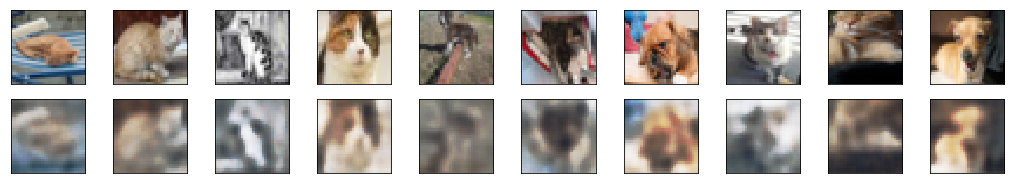

In [21]:
fig, ax = plt.subplots( 2, 10, figsize=(18, 3) )

for nn in range( 10 ):
    ax[0,nn].get_xaxis().set_visible( False )
    ax[0,nn].get_yaxis().set_visible( False )
    ax[1,nn].get_xaxis().set_visible( False )
    ax[1,nn].get_yaxis().set_visible( False )
    
    img = np.squeeze( train_im[nn,:,:,:] )
    rec = np.squeeze( train_re[nn,:,:,:] )
    
    ax[0,nn].imshow( img )
    ax[1,nn].imshow( rec )

# Visualize testing reconstruction
This always involves the full data set

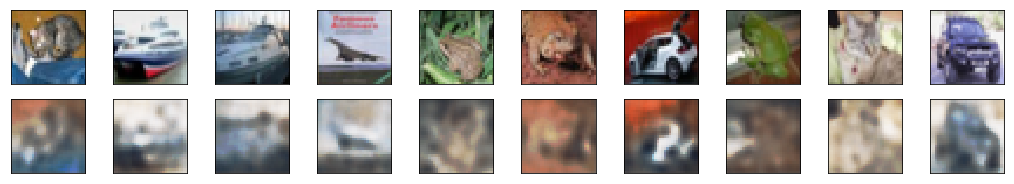

In [22]:
fig, ax = plt.subplots( 2, 10, figsize=(18, 3) )

for nn in range( 10 ):
    ax[0,nn].get_xaxis().set_visible( False )
    ax[0,nn].get_yaxis().set_visible( False )
    ax[1,nn].get_xaxis().set_visible( False )
    ax[1,nn].get_yaxis().set_visible( False )
    
    img = np.squeeze( test_im[nn,:,:,:] )
    rec = np.squeeze( test_re[nn,:,:,:] )
    
    ax[0,nn].imshow( img )
    ax[1,nn].imshow( rec )

In [23]:
with tf.Session() as sess:
    saver.restore( sess, ckpt_fname )
    
    sess.run( training_init_op )
    images_, code_, recon_ = sess.run( [images, code, recon] )
    
# Now, we need to freeze the trained part of the network, attach a tan, and have it learn the likelihoods

INFO:tensorflow:Restoring parameters from ./ckpt/cifar-010-partial_25_64.ckpt


In [24]:
# restore_var = tf.contrib.slim.get_variables( scope='encoder' )

loader = tf.train.Saver() # restore_var )

with tf.Session() as sess:
    loader.restore( sess, ckpt_fname )
    
    sess.run( training_init_op )
    slim_images_, slim_code_ = sess.run( [images, code] )

print( np.shape( slim_code_ ) )

INFO:tensorflow:Restoring parameters from ./ckpt/cifar-010-partial_25_64.ckpt
(64, 128)


In [25]:
def loglikely( code ):
    with tf.variable_scope( 'loglikely' ):
        stop_layer = tf.stop_gradient( code )
        
        nll, samp = tan_nll( stop_layer )
        
        return nll, samp

In [26]:
nll, _ = loglikely( code )

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay( 
    learning_rate=0.001, 
    global_step=global_step,
    decay_steps=int( ( 50000 / ( 2 * batch_size ) ) ), 
    decay_rate=0.99, 
    staircase=True
)

Building tan Graph,
	conditioning None
[<function log_rescale.<locals>.invmap at 0x7fe7931fd268>, <function log_rescale.<locals>.invmap at 0x7fe7931fd1e0>, <function log_rescale.<locals>.invmap at 0x7fe7931fd158>, <function log_rescale.<locals>.invmap at 0x7fe7b01bdb70>, <function log_rescale.<locals>.invmap at 0x7fe7b01bdf28>, <function log_rescale.<locals>.invmap at 0x7fe7b01bdea0>, <function log_rescale.<locals>.invmap at 0x7fe7b01bdbf8>, <function log_rescale.<locals>.invmap at 0x7fe7b01bdd90>, <function get_LU_map.<locals>.invmap at 0x7fe7b01bda60>]


In [27]:
# train_op = tf.train.MomentumOptimizer( learning_rate=learning_rate, momentum=0.9 ).minimize( nll )
# train_op = tf.train.AdamOptimizer( learning_rate=learning_rate ).minimize( nll )
nll_op = tf.train.RMSPropOptimizer( learning_rate ).minimize( nll )

In [30]:
NLL_EPOCHS = 250
nll_saver = tf.train.Saver()

if ( train_on_full ):
    nll_ckpt_fname = "./ckpt/cifar-010-nll-full_{}_{}.ckpt".format( NLL_EPOCHS, batch_size )
else:
    nll_ckpt_fname = "./ckpt/cifar-010-nll-partial_{}_{}.ckpt".format( NLL_EPOCHS, batch_size )

with tf.Session() as sess:
    # Initialize the session
    sess.run( tf.global_variables_initializer() )
    
    # Overload the encoder parameters with those already learned
    loader.restore( sess, ckpt_fname )
    
    all_train_nll = []
    all_test_nll = []
    all_test_loss = []
    for ee in range( NLL_EPOCHS ):
        
        cnt = 0
        train_nll = 0.0
        
        # Set up the training data
        sess.run( training_init_op )
        while True:
            try:
                # Test the nll
                _, nll_ = sess.run( [nll_op, nll] )
                cnt += 1
            except tf.errors.OutOfRangeError:
                break
            train_nll += nll_
        
        train_nll = train_nll / cnt
        print( "The average training nll at epic {} was {} with {} steps.".format( ee, train_nll, cnt ) )
        all_train_nll.append( train_nll )
    
        cnt = 0
        test_nll = 0.0
        test_loss = 0.0
        # Run some number of testing batches in this epoch
        sess.run( testing_init_op )
        while True:
            try:
                # TODO: I need the nll and label per test example
                nll_, loss_ = sess.run( [nll,loss] )
                cnt += 1
            except tf.errors.OutOfRangeError:
                break
            test_nll += nll_
            test_loss += loss_
        
        test_nll = test_nll / cnt
        test_loss = test_loss / cnt
        print( "The average testing nll/loss at epic {} was {}/{} with {} steps".format( ee, test_nll, test_loss, cnt ) )
        all_test_nll.append( test_nll )
        all_test_loss.append( test_loss )
    
    nll_save_path = nll_saver.save( sess, nll_ckpt_fname )

INFO:tensorflow:Restoring parameters from ./ckpt/cifar-010-partial_25_64.ckpt
The average training nll at epic 0 was 249.5589991838504 with 156 steps.
The average testing nll/loss at epic 0 was 209.88338568271735/0.011155808607164102 with 156 steps
The average training nll at epic 1 was 196.87992291572766 with 156 steps.
The average testing nll/loss at epic 1 was 189.67730223826874/0.011155808601194086 with 156 steps
The average training nll at epic 2 was 185.07719215979944 with 156 steps.
The average testing nll/loss at epic 2 was 187.06068664942032/0.011155808625074152 with 156 steps
The average training nll at epic 3 was 179.4732547662197 with 156 steps.
The average testing nll/loss at epic 3 was 186.3790756616837/0.01115580857731402 with 156 steps
The average training nll at epic 4 was 175.1970364497258 with 156 steps.
The average testing nll/loss at epic 4 was 184.8017797225561/0.011155808619104134 with 156 steps
The average training nll at epic 5 was 171.32513271233975 with 156 s

The average testing nll/loss at epic 47 was 296.75745548346106/0.011155808619104134 with 156 steps
The average training nll at epic 48 was 112.43755428607648 with 156 steps.
The average testing nll/loss at epic 48 was 289.7675491724259/0.011155808631044168 with 156 steps
The average training nll at epic 49 was 112.07022383274176 with 156 steps.
The average testing nll/loss at epic 49 was 295.1340543306791/0.01115580857731402 with 156 steps
The average training nll at epic 50 was 111.02513435559395 with 156 steps.
The average testing nll/loss at epic 50 was 302.8976546067458/0.011155808571344003 with 156 steps
The average training nll at epic 51 was 110.4569794092423 with 156 steps.
The average testing nll/loss at epic 51 was 310.6812268770658/0.01115580854149392 with 156 steps
The average training nll at epic 52 was 109.56521195631761 with 156 steps.
The average testing nll/loss at epic 52 was 311.5677232008714/0.011155808607164102 with 156 steps
The average training nll at epic 53 was

The average training nll at epic 95 was 87.5901888822898 with 156 steps.
The average testing nll/loss at epic 95 was 411.63045423458783/0.011155808678804299 with 156 steps
The average training nll at epic 96 was 87.10403911884015 with 156 steps.
The average testing nll/loss at epic 96 was 411.1165540646284/0.011155808589254051 with 156 steps
The average training nll at epic 97 was 86.70437362866524 with 156 steps.
The average testing nll/loss at epic 97 was 410.8215999114208/0.011155808613134118 with 156 steps
The average training nll at epic 98 was 86.46988032414363 with 156 steps.
The average testing nll/loss at epic 98 was 420.9398134671725/0.01115580857731402 with 156 steps
The average training nll at epic 99 was 85.92466320135655 with 156 steps.
The average testing nll/loss at epic 99 was 416.1111497145433/0.011155808637014184 with 156 steps
The average training nll at epic 100 was 85.61930049994054 with 156 steps.
The average testing nll/loss at epic 100 was 418.9121383275741/0.0

The average testing nll/loss at epic 142 was 470.58336228590747/0.011155808613134118 with 156 steps
The average training nll at epic 143 was 75.71049709809132 with 156 steps.
The average testing nll/loss at epic 143 was 467.97664603208887/0.011155808607164102 with 156 steps
The average training nll at epic 144 was 75.25158618046687 with 156 steps.
The average testing nll/loss at epic 144 was 488.62139383951825/0.011155808613134118 with 156 steps
The average training nll at epic 145 was 75.18192770542242 with 156 steps.
The average testing nll/loss at epic 145 was 477.9610349214994/0.011155808637014184 with 156 steps
The average training nll at epic 146 was 75.11646935878656 with 156 steps.
The average testing nll/loss at epic 146 was 475.085569528433/0.011155808637014184 with 156 steps
The average training nll at epic 147 was 74.81659859877367 with 156 steps.
The average testing nll/loss at epic 147 was 472.2843322753906/0.011155808631044168 with 156 steps
The average training nll at e

The average training nll at epic 190 was 68.87521990751608 with 156 steps.
The average testing nll/loss at epic 190 was 508.34514676607574/0.011155808666864267 with 156 steps
The average training nll at epic 191 was 68.57708033537253 with 156 steps.
The average testing nll/loss at epic 191 was 518.3085378011068/0.011155808654924234 with 156 steps
The average training nll at epic 192 was 68.52627976735432 with 156 steps.
The average testing nll/loss at epic 192 was 520.5584370539739/0.011155808625074152 with 156 steps
The average training nll at epic 193 was 68.40270164685371 with 156 steps.
The average testing nll/loss at epic 193 was 517.5610783894857/0.011155808613134118 with 156 steps
The average training nll at epic 194 was 68.35595759367331 with 156 steps.
The average testing nll/loss at epic 194 was 522.8855729714418/0.011155808631044168 with 156 steps
The average training nll at epic 195 was 68.23889040335631 with 156 steps.
The average testing nll/loss at epic 195 was 524.53731

The average testing nll/loss at epic 237 was 552.7505277976012/0.01115580859522407 with 156 steps
The average training nll at epic 238 was 63.92588192377335 with 156 steps.
The average testing nll/loss at epic 238 was 554.3261906550481/0.011155808601194086 with 156 steps
The average training nll at epic 239 was 63.775991390912964 with 156 steps.
The average testing nll/loss at epic 239 was 549.9208553998898/0.011155808535523904 with 156 steps
The average training nll at epic 240 was 63.595846102787895 with 156 steps.
The average testing nll/loss at epic 240 was 559.3393202561599/0.011155808625074152 with 156 steps
The average training nll at epic 241 was 63.91286497849684 with 156 steps.
The average testing nll/loss at epic 241 was 558.7197723388672/0.011155808571344003 with 156 steps
The average training nll at epic 242 was 63.608598220042694 with 156 steps.
The average testing nll/loss at epic 242 was 552.2870362110627/0.011155808601194086 with 156 steps
The average training nll at e

TypeError: 'Saver' object is not callable

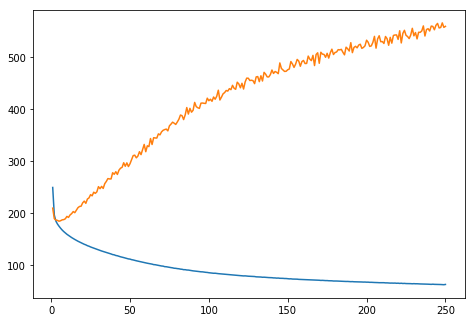

In [32]:
fig = plt.figure( )
ax = fig.add_axes( (0,0,1,1) )

x = np.arange( 1, NLL_EPOCHS+1 )
ax.plot( x, np.array( all_train_nll ) )
ax.plot( x, np.array( all_test_nll ) )

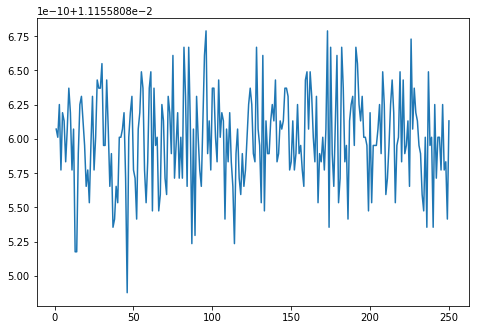

In [33]:
fig = plt.figure( )
ax = fig.add_axes( (0,0,1,1) )

ax.plot( x, np.array( all_test_loss ) )